# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import operator

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',delimiter=';')


In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
#print (feat_info.head(),azdias.head())

feat_info[(feat_info.type=='mixed') | (feat_info.type=='multilevel')]

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [4]:
# Identify missing or unknown data values and convert them to NaNs.
columns=[x for x in feat_info['attribute']] 
mappings_list = [] 
mappings = {}
for x in feat_info.iterrows():
    start=x[1][3].find('[') 
    end=x[1][3].find(']') 
    mappings[x[1][0]]=x[1][3][start+1:(end)].split(",")

for col in mappings: 
    a = {} 
    for vals in mappings[col]:
        if len(vals)>0:
            if vals=='X' or vals=='XX': 
                a[vals]=np.nan 
                mappings[col]=a 
                mappings_list.append({col:mappings[col]}) 
            else:
                vals=np.int64(vals)
                a[vals]=np.nan
                mappings[col]=a 
                mappings_list.append({col:mappings[col]})

        else:
            continue
            
df = azdias.copy()
for item in mappings_list:
    df.replace(item, inplace=True)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [5]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
s=df.isnull().sum().sort_values(ascending=False)/len(df)

'''
'REGIOTYP', 'KKK'
'KBA05_ANTG4','KBA05_GBZ',
'KBA05_ANTG1','KBA05_ANTG2','KBA05_ANTG3'
'PLZ8_GBZ','PLZ8_HHZ','PLZ8_BAUMAX','PLZ8_ANTG4','PLZ8_ANTG1','PLZ8_ANTG3','PLZ8_ANTG2'
'SEMIO_LUST',SEMIO_ERL','SEMIO_KULT','SEMIO_RAT','SEMIO_KRIT'
'''
s[-10:]

SEMIO_LUST       0.0
SEMIO_ERL        0.0
SEMIO_KULT       0.0
SEMIO_RAT        0.0
SEMIO_KRIT       0.0
SEMIO_DOM        0.0
SEMIO_KAEM       0.0
SEMIO_PFLICHT    0.0
SEMIO_TRADV      0.0
ZABEOTYP         0.0
dtype: float64

In [6]:
# Investigate patterns in the amount of missing data in each column.

sorted_df=(df.isnull().sum()/len(df)).sort_values(ascending=False)

sorted_df.index

Index(['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR',
       'ALTER_HH', 'REGIOTYP', 'KKK', 'W_KEIT_KIND_HH', 'KBA05_ANTG4',
       'KBA05_GBZ', 'MOBI_REGIO', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3',
       'PLZ8_GBZ', 'PLZ8_HHZ', 'PLZ8_BAUMAX', 'PLZ8_ANTG4', 'PLZ8_ANTG1',
       'PLZ8_ANTG3', 'PLZ8_ANTG2', 'SHOPPER_TYP', 'VERS_TYP', 'HEALTH_TYP',
       'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'KBA13_ANZAHL_PKW',
       'ANZ_HAUSHALTE_AKTIV', 'CAMEO_INTL_2015', 'CAMEO_DEU_2015',
       'CAMEO_DEUG_2015', 'LP_LEBENSPHASE_FEIN', 'RELAT_AB', 'ARBEIT',
       'ORTSGR_KLS9', 'ANZ_HH_TITEL', 'LP_LEBENSPHASE_GROB', 'INNENSTADT',
       'EWDICHTE', 'BALLRAUM', 'GEBAEUDETYP_RASTER', 'MIN_GEBAEUDEJAHR',
       'GEBAEUDETYP', 'WOHNLAGE', 'OST_WEST_KZ', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'KONSUMNAEHE', 'ANZ_PERSONEN', 'SOHO_KZ',
       'ANZ_TITEL', 'WOHNDAUER_2008', 'HH_EINKOMMEN_SCORE', 'CJT_GESAMTTYP',
       'RETOURTYP_BK_S', 'ONLINE_AFFINITAET', 'LP_S

#### The amount of missing data in the top 6 columns displayed above have missing data with proportion of missing data to be more than 20%.We might have to remove these columns .

In [7]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

#remove top 6 columns which have way more missing values than the other columns
cols_to_remove=list(sorted_df[:6].index)


cleaned_df=df.drop(cols_to_remove,axis=1)
cols_to_remove

['TITEL_KZ',
 'AGER_TYP',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX',
 'GEBURTSJAHR',
 'ALTER_HH']

In [8]:
len(cleaned_df.columns)

79

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

- I found that the top 6 columns had more than 20% of  NA's in their columns and decided to drop only those columns
- The columns dropped are :
'TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR','ALTER_HH'

- Some columns seemed to have the same amount of NA proportions in their columns .Some of them are :

['REGIOTYP', 'KKK']
['KBA05_ANTG4','KBA05_GBZ',]
['KBA05_ANTG1','KBA05_ANTG2','KBA05_ANTG3']
['PLZ8_GBZ','PLZ8_HHZ','PLZ8_BAUMAX','PLZ8_ANTG4','PLZ8_ANTG1','PLZ8_ANTG3','PLZ8_ANTG2']

-Some columns have no missing values at all .For eg:

'SEMIO_LUST',SEMIO_ERL','SEMIO_KULT','SEMIO_RAT','SEMIO_KRIT'




#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

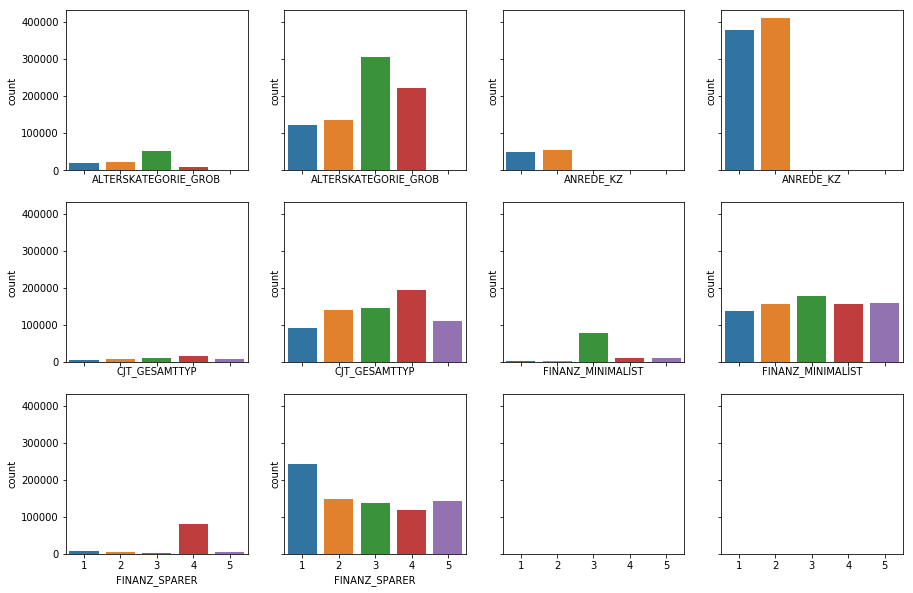

In [9]:
cols_to_compare=cleaned_df.columns[:5]


#chose a threshold of 15 to differentiate 
greater_than_threshold=cleaned_df[cleaned_df.isnull().sum(axis=1)>=15]
lesser_than_threshold=cleaned_df[cleaned_df.isnull().sum(axis=1)<15]
#cleaned_df[cleaned_df.isnull().sum(axis=1).sort_values(ascending=False)>15]


fig,ax =plt.subplots(3,4,figsize=(15,10),sharex=True,sharey=True)

ax1=sns.countplot(x=cols_to_compare[0],data=greater_than_threshold,ax=ax[0][0])
ax2=sns.countplot(x=cols_to_compare[0],data=lesser_than_threshold, ax=ax[0][1])
ax3=sns.countplot(x=cols_to_compare[1],data=greater_than_threshold, ax=ax[0][2])
ax4=sns.countplot(x=cols_to_compare[1],data=lesser_than_threshold, ax=ax[0][3])

ax5=sns.countplot(x=cols_to_compare[2],data=greater_than_threshold,ax=ax[1][0])
ax6=sns.countplot(x=cols_to_compare[2],data=lesser_than_threshold, ax=ax[1][1])
ax7=sns.countplot(x=cols_to_compare[3],data=greater_than_threshold, ax=ax[1][2])
ax8=sns.countplot(x=cols_to_compare[3],data=lesser_than_threshold, ax=ax[1][3])

ax9=sns.countplot(x=cols_to_compare[4],data=greater_than_threshold,ax=ax[2][0])
ax10=sns.countplot(x=cols_to_compare[4],data=lesser_than_threshold, ax=ax[2][1])






#### Based on what we see above data does vary between rows which have a few columns missing versus columns which have more than few missing.Lets leave out the data with more than few missing values in this case to be dealt with later and continue with analysis of data for the few missing columns cells.

##### Note: By few, we mean that columns which have a threshold of more than 15 columns missing 


#### Discussion 1.1.3: Assess Missing Data in Each Row

I have chosen a threshold of 15 beyond which we can consider them to be rows which have a lot of missing values.We can consider the rows with few missing values now for our analysis and go forward .



### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [10]:
# How many features are there of each data type?

feat_info['type'].value_counts()



ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [11]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
encoded=lesser_than_threshold.copy()

#Identify the differnet type columns
categorical_cols=[col for col in feat_info[feat_info.type=='categorical']['attribute'] if col in encoded.columns]
ordinal_cols=[col for col in feat_info[feat_info.type=='ordinal']['attribute'] if col in encoded.columns]
mixed_cols=[col for col in feat_info[feat_info.type=='mixed']['attribute'] if col in encoded.columns]


multilevel_categoricals=[]
binary_categoricals=[]


for idx,col in enumerate(categorical_cols):
    if len(encoded[categorical_cols[idx]].value_counts())>=3:
        multilevel_categoricals.append(col)
    
    elif len(encoded[categorical_cols[idx]].value_counts())==2:
        binary_categoricals.append(col)
        
    else:
        print (col)
        



In [12]:
#replace 44 non numeric values to numeric values
encode_map=dict(zip(encoded['CAMEO_DEU_2015'].unique(),(list(range(0,len(encoded['CAMEO_DEU_2015'].unique()))))))

encoded['CAMEO_DEU_2015']=encoded['CAMEO_DEU_2015'].replace(encode_map)


In [13]:
#Encoding non numeric col to represent 1 and 0
encoded['OST_WEST_KZ']=encoded['OST_WEST_KZ'].replace({'W':1,'O':0})
encoded['OST_WEST_KZ'].value_counts()


1    620787
0    166757
Name: OST_WEST_KZ, dtype: int64

In [14]:
cols_to_impute=[]
for col in feat_info[feat_info.type=='categorical']['attribute']:
    if col in encoded:#check to see if some of the columns have already been treated by us
        if encoded[col].isnull().sum():
            cols_to_impute.append(col)

#### It appears as if there are some na values in the categorical columns .Let us go ahead and impute thes columns the na rows as we consider this part of the data to have only few na's and dropping these NaN rows wont have a significant impact.

In [15]:

from sklearn.preprocessing import Imputer

impute=Imputer(missing_values='NaN',strategy='median')

encoded_temp=impute.fit_transform(encoded.values)
encoded=pd.DataFrame(encoded_temp,columns=encoded.columns)



In [16]:
len(encoded.columns)

79

In [17]:
for col in multilevel_categoricals:
    print (col,encoded[col].value_counts(dropna=False))

CJT_GESAMTTYP 4.0    199740
3.0    145030
2.0    140428
5.0    110108
6.0    100017
1.0     92221
Name: CJT_GESAMTTYP, dtype: int64
FINANZTYP 6.0    288034
1.0    194408
5.0    105447
2.0    103343
4.0     55468
3.0     40844
Name: FINANZTYP, dtype: int64
GFK_URLAUBERTYP 12.0    127379
10.0    101896
8.0      86673
11.0     74343
5.0      70195
4.0      60348
9.0      56240
3.0      53032
1.0      50415
2.0      41007
7.0      40382
6.0      25634
Name: GFK_URLAUBERTYP, dtype: int64
LP_FAMILIE_FEIN 1.0     428412
10.0    127869
2.0      97036
11.0     48404
8.0      21506
7.0      19019
4.0      11395
5.0      11059
9.0      10348
6.0       8011
3.0       4485
Name: LP_FAMILIE_FEIN, dtype: int64
LP_FAMILIE_GROB 1.0    428412
5.0    186621
2.0     97036
4.0     48536
3.0     26939
Name: LP_FAMILIE_GROB, dtype: int64
LP_STATUS_FEIN 1.0     205688
9.0     133108
2.0     110468
10.0    110435
4.0      77931
3.0      68667
6.0      28481
5.0      26793
8.0      16864
7.0       9109
Name: LP

In [18]:
#one hot encode multilevel categorical columns


for col in multilevel_categoricals:
    
    trans=OneHotEncoder(sparse=False)
    
    transformed_columns=trans.fit_transform(encoded[col].reshape(-1,1))
    
    
    temp=pd.DataFrame(transformed_columns,columns=[(col+"_"+str(i)) for i in encoded[col].value_counts().index])
    
    temp=temp.set_index(encoded.index.values)
    
    encoded=pd.concat([encoded,temp],axis=1)
    
#transformed_columns


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


In [19]:
#drop original columns after they have been one hot encoded
encoded=encoded.drop(multilevel_categoricals,axis=1)

In [20]:
encoded.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP',
       ...
       'CAMEO_DEU_2015_42.0', 'CAMEO_DEU_2015_30.0', 'CAMEO_DEU_2015_19.0',
       'CAMEO_DEU_2015_8.0', 'CAMEO_DEU_2015_40.0', 'CAMEO_DEU_2015_18.0',
       'CAMEO_DEU_2015_43.0', 'CAMEO_DEU_2015_44.0', 'CAMEO_DEU_2015_16.0',
       'CAMEO_DEU_2015_31.0'],
      dtype='object', length=195)

#### Discussion 1.2.1: Re-Encode Categorical Features


I did not choose to drop any feature .I chose to keep it and performed the following modifications listed below:

- OST_WEST_KZ : replaced values with binary mappings
- CAMEO_DEU_2015 : as they were non numerical in nature ,i chose to encode it using numerical values 
- multilevel categorical columns :  -imputed NaN's with sklearn Imputer object and replaced all the multilevel categorical columns with One Hot Encoding


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [21]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
def encode_movement(x):
    '''
    takes in a dataframe x and re-engineers 2 new features,
    Decade and Movement based on values of PRAEGENDE_JUGENDJAHRE.
    
    inputs:
    a dataframe 
    
    output:
    returns the modified dataframe adding 2 new columns 
    '''
    x=str(x)
    if x in [1,3,5,8,10,12,14]:
        return 1
        
    elif x  in [2,4,6,7,9,11,13,15]:
        return 0
    
    else:
        return 1000
    
    
    return


def encode_decade(x):
    
    '''
    takes in a series x and engineers a new feature,
    Decade  based on values of PRAEGENDE_JUGENDJAHRE.
    
    inputs:
    a series 
    
    output:
    returns the modified series  
    '''
    
    x=str(x)
    if x  in [1,2]:
        return 40
        
    elif x in [3,4]:
        return 50
        
    elif x  in [5,6,7]:
        return 60
        
    elif x  in [8,9]:
        return 70
        
    elif x  in [10,11,12,13]:
        return 80
        
    elif x in [14,15]:
        return 90
        
    else:
        return 1000
        
    
    
encoded['Decade']=encoded['PRAEGENDE_JUGENDJAHRE'].apply(encode_decade)
encoded['Movement']=encoded['PRAEGENDE_JUGENDJAHRE'].apply(encode_movement)



In [22]:
encoded['CAMEO_INTL_2015']=encoded['CAMEO_INTL_2015'].astype('float')


In [23]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
def encode_wealth(x):
    return x/10

def encode_life_stage(x):
    return x%10


encoded['life_stage']=encoded['CAMEO_INTL_2015'].apply(encode_life_stage)
encoded['wealth']=encoded['CAMEO_INTL_2015'].apply(encode_wealth)



#### LP_LEBENSPHASE_FEIN
Based on observation of values in this column we can say that we can split it up into a age variable,earning potential variable and a family variable.But this information is already captured by the other columns . LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,.etc .Lets go through the other columns before taking a final decision on which column to drop


#### LP_LEBENSPHASE_GROB
This column does have the same information as the column above but at a broader level of granularity than LP_LEBENSPHASE_FEIN.So we can either choose to drop this column or the column above as they essentially have the same details ,but it will be nice to have a column which  has much more details to it   than less details.So this column is a good candidate to be considered for dropping


#### WOHNLAGE
This column has information on neighborhood quality as well as rural flag.It is not advisable to keep information on both neighborhood quality and rural flag as we know every column is supposed to have data related to one particular variable alone.As it captures 2 differnet variables we can consider dropping the data withe the least amount of information in this variable i.e. rural flag 


#### PLZ8_BAUMAX
This variable captures data related to the type of building i.e. business/family home and number of family homes.Lets try to keep it to describe one variable alone .Lets keep this variable to mean number of family homes alone i.e whether its a 2 family ,3 family or 4 family etc.



In [24]:
encoded=encoded.drop('LP_LEBENSPHASE_GROB',axis=1)
encoded["WOHNLAGE"] = encoded["WOHNLAGE"].apply(lambda x: 1000 if (x == 7)|(x == 8) else x)
encoded['PLZ8_BAUMAX']=encoded['PLZ8_BAUMAX'].apply(lambda x :1000 if x==5  else x)

#### Discussion 1.2.2: Engineer Mixed-Type Features

- created 4 new features from 'CAMEO_INTL_2015' and 'PRAEGENDE_JUGENDJAHRE'
- LP_LEBENSPHASE_GROB:Decided to drop this column because  LP_LEBENSPHASE_GROB and LP_LEBENSPHASE_FEIN have the same information and i decided to keep just one for the analysis dropping the other 
- WOHNLAGE:Changed this feature to mean description of only one variable i.e neighborhood quality
- PLZ8_BAUMAX This column captured data related  to the type of building business/family home or number of family homes.I decided to make this column signify one level of information only and decided to drop the values of business home which was a value of 5

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [25]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
fully_encoded=encoded.copy()
fully_encoded=fully_encoded.drop(['CAMEO_INTL_2015','PRAEGENDE_JUGENDJAHRE'],axis=1)


In [26]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
fully_encoded.columns


Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP',
       ...
       'CAMEO_DEU_2015_40.0', 'CAMEO_DEU_2015_18.0', 'CAMEO_DEU_2015_43.0',
       'CAMEO_DEU_2015_44.0', 'CAMEO_DEU_2015_16.0', 'CAMEO_DEU_2015_31.0',
       'Decade', 'Movement', 'life_stage', 'wealth'],
      dtype='object', length=196)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [27]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    
    
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    columns=[x for x in feat_info['attribute']] 
    mappings_list = [] 
    mappings = {}
    for x in feat_info.iterrows():
        start=x[1][3].find('[') 
        end=x[1][3].find(']') 
        mappings[x[1][0]]=x[1][3][start+1:(end)].split(",")

    for col in mappings: 
        a = {} 
        for vals in mappings[col]:
            if len(vals)>0:
                if vals=='X' or vals=='XX': 
                    a[vals]=np.nan 
                    mappings[col]=a 
                    mappings_list.append({col:mappings[col]}) 
                else:
                    vals=np.int64(vals)
                    a[vals]=np.nan
                    mappings[col]=a 
                    mappings_list.append({col:mappings[col]})

            else:
                continue

    df = azdias.copy()
    for item in mappings_list:
        df.replace(item, inplace=True)

    ### remove selected columns and rows, ...
    
    #hard_Code the columns to remove
    cols_to_remove=['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR','ALTER_HH']
    
    cleaned_df=df.drop(cols_to_remove,axis=1)

    
    
    #Choose a threshold
    greater_than_threshold=cleaned_df[cleaned_df.isnull().sum(axis=1)>=15]
    lesser_than_threshold=cleaned_df[cleaned_df.isnull().sum(axis=1)<15]
    encoded=lesser_than_threshold.copy()

    #Identify the differnt type columns
    categorical_cols=[col for col in feat_info[feat_info.type=='categorical']['attribute'] if col in encoded.columns]
    ordinal_cols=[col for col in feat_info[feat_info.type=='ordinal']['attribute'] if col in encoded.columns]
    mixed_cols=[col for col in feat_info[feat_info.type=='mixed']['attribute'] if col in encoded.columns]


    multilevel_categoricals=[]
    binary_categoricals=[]


    for idx,col in enumerate(categorical_cols):
        if len(encoded[categorical_cols[idx]].value_counts())>=3:
            multilevel_categoricals.append(col)

        elif len(encoded[categorical_cols[idx]].value_counts())==2:
            binary_categoricals.append(col)

        else:
            print (col)
            
            
    #replace 44 non numeric values to numeric values
    encode_map=dict(zip(encoded['CAMEO_DEU_2015'].unique(),(list(range(0,len(encoded['CAMEO_DEU_2015'].unique()))))))

    encoded['CAMEO_DEU_2015']=encoded['CAMEO_DEU_2015'].replace(encode_map)       

    #Encoding non numeric col to represent 1 and 0
    encoded['OST_WEST_KZ']=encoded['OST_WEST_KZ'].replace({'W':1,'O':0})
    encoded['OST_WEST_KZ'].value_counts()

    cols_to_impute=[]
    for col in feat_info[feat_info.type=='categorical']['attribute']:
        if col in encoded:#check to see if some of the columns have already been treated by us
            if encoded[col].isnull().sum():
                cols_to_impute.append(col)

    from sklearn.preprocessing import Imputer

    impute=Imputer(missing_values='NaN',strategy='median')

    encoded_temp=impute.fit_transform(encoded.values)
    encoded=pd.DataFrame(encoded_temp,columns=encoded.columns)

    for col in multilevel_categoricals:

        trans=OneHotEncoder(sparse=False)

        transformed_columns=trans.fit_transform(encoded[col].reshape(-1,1))


        temp=pd.DataFrame(transformed_columns,columns=[(col+"_"+str(i)) for i in encoded[col].value_counts().index])

        temp=temp.set_index(encoded.index.values)

        encoded=pd.concat([encoded,temp],axis=1)

    #drop original columns after they have been one hot encoded
    encoded=encoded.drop(multilevel_categoricals,axis=1)

    encoded['Decade']=encoded['PRAEGENDE_JUGENDJAHRE'].apply(encode_decade)
    encoded['Movement']=encoded['PRAEGENDE_JUGENDJAHRE'].apply(encode_movement)
    encoded['CAMEO_INTL_2015']=encoded['CAMEO_INTL_2015'].astype('float')

    encoded['life_stage']=encoded['CAMEO_INTL_2015'].apply(encode_life_stage)
    encoded['wealth']=encoded['CAMEO_INTL_2015'].apply(encode_wealth)

    encoded=encoded.drop('LP_LEBENSPHASE_GROB',axis=1)
    encoded["WOHNLAGE"] = encoded["WOHNLAGE"].apply(lambda x: 1000 if (x == 7)|(x == 8) else x)
    encoded['PLZ8_BAUMAX']=encoded['PLZ8_BAUMAX'].apply(lambda x :1000 if x==5  else x)

    fully_encoded=encoded.copy()
    fully_encoded=fully_encoded.drop(['CAMEO_INTL_2015','PRAEGENDE_JUGENDJAHRE'],axis=1) 
     

    # Return the cleaned dataframe and greater_than_threshold dataframe.
    return lesser_than_threshold,fully_encoded,greater_than_threshold
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [28]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

fully_encoded_copy=fully_encoded.copy()


In [29]:
# Apply feature scaling to the general population demographics data.
scaler=StandardScaler()
fully_encoded_scaled=scaler.fit_transform(fully_encoded_copy.values)

fully_encoded_scaled=pd.DataFrame(fully_encoded_scaled,columns=fully_encoded_copy.columns)

In [30]:
fully_encoded_scaled

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_40.0,CAMEO_DEU_2015_18.0,CAMEO_DEU_2015_43.0,CAMEO_DEU_2015_44.0,CAMEO_DEU_2015_16.0,CAMEO_DEU_2015_31.0,Decade,Movement,life_stage,wealth
0,-1.767361,0.958218,-1.490890,1.539288,-1.043949,1.467187,0.972646,1.331434,-0.531361,1.091802,...,-0.140338,-0.07644,-0.093567,-0.082562,-0.073695,-0.073695,0.0,0.0,-1.250002,1.099478
1,0.198968,0.958218,-1.490890,0.866362,-1.770337,-0.569182,0.256102,1.331434,1.881961,1.091802,...,-0.140338,-0.07644,-0.093567,-0.082562,-0.073695,-0.073695,0.0,0.0,0.764297,-0.828710
2,1.182132,0.958218,0.686283,-0.479491,1.135215,-0.569182,-1.176986,-0.808128,-0.531361,-0.261206,...,-0.140338,-0.07644,-0.093567,-0.082562,-0.073695,-0.073695,0.0,0.0,-0.578569,-1.685682
3,0.198968,-1.043604,0.686283,0.193436,0.408827,-1.247971,0.256102,-0.808128,-0.531361,1.091802,...,-0.140338,-0.07644,-0.093567,-0.082562,-0.073695,-0.073695,0.0,0.0,0.092864,0.528163
4,-1.767361,0.958218,-0.039441,-1.152417,1.135215,-0.569182,-0.460442,1.331434,-0.531361,1.091802,...,-0.140338,-0.07644,-0.093567,-0.082562,-0.073695,-0.073695,0.0,0.0,0.764297,1.313721
5,-0.784197,0.958218,-1.490890,1.539288,-1.770337,1.467187,0.972646,-0.094941,-0.531361,-0.261206,...,-0.140338,-0.07644,-0.093567,-0.082562,-0.073695,-0.073695,0.0,0.0,-0.578569,-0.971539
6,-1.767361,-1.043604,-0.039441,0.193436,0.408827,-1.247971,0.256102,-0.808128,-0.531361,-1.614214,...,-0.140338,-0.07644,-0.093567,-0.082562,-0.073695,-0.073695,0.0,0.0,0.764297,-1.542854
7,0.198968,-1.043604,0.686283,0.866362,-1.043949,0.788397,-0.460442,-0.808128,1.881961,1.091802,...,-0.140338,-0.07644,-0.093567,-0.082562,-0.073695,-0.073695,0.0,0.0,0.092864,-1.614268
8,0.198968,0.958218,-0.765166,0.866362,-1.043949,0.109608,1.689190,0.618247,1.881961,-0.261206,...,-0.140338,-0.07644,-0.093567,-0.082562,-0.073695,-0.073695,0.0,0.0,1.435730,-1.471439
9,0.198968,0.958218,-0.765166,-0.479491,1.135215,0.109608,-1.176986,1.331434,-0.531361,-0.261206,...,-0.140338,-0.07644,-0.093567,-0.082562,-0.073695,-0.073695,0.0,0.0,-1.250002,1.099478


### Discussion 2.1: Apply Feature Scaling

* Before we can go ahead with feature scaling we have to ensure that we removed all NaN's in the dataset.Here as we have performed data manipulations to remove NaN's both row wise and column wise we can go ahead and perform scaling

* I decided to go in with standard feature scaling using the Standard Scaler object from sklearn library


### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [31]:
# Apply PCA to the data.
pca=PCA(random_state=47)
pca_applied=pca.fit_transform(fully_encoded_scaled.values)



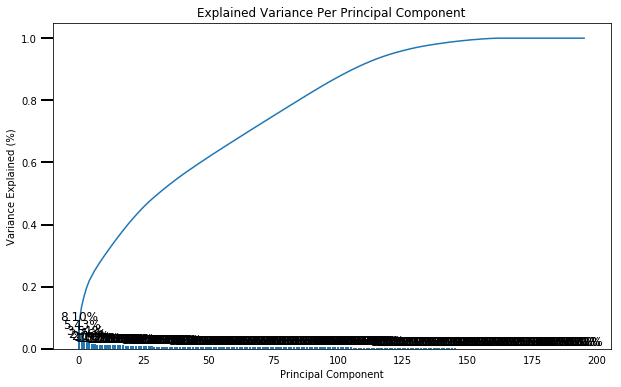

In [32]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
scree_plot(pca)

In [33]:

#lets check the amount of components that explain cumulative variance
for idx,els in enumerate(np.cumsum(pca.explained_variance_ratio_).tolist()):
    print  (idx,els)

0 0.08100116167248558
1 0.13532294467152522
2 0.1704462803837193
3 0.19810154620410064
4 0.2197892003685335
5 0.2358386792457969
6 0.25112262638865385
7 0.2644227246854774
8 0.2774483899925741
9 0.29001529109527535
10 0.3020542863918415
11 0.3138787723246666
12 0.3255231183504368
13 0.33693418217540555
14 0.34820315825811715
15 0.35922928859105696
16 0.37010560374431495
17 0.3807909093491433
18 0.39124941952675796
19 0.4016012428824399
20 0.41155806888179314
21 0.42114685312483596
22 0.43054951081383397
23 0.43968512590202213
24 0.44851596032554997
25 0.4571146900989755
26 0.4654875277857082
27 0.473468531403935
28 0.4809407956719431
29 0.48818625276718813
30 0.49529002084363005
31 0.5023380578480012
32 0.5092701527328611
33 0.5160632436226517
34 0.522740040312743
35 0.5293080195175417
36 0.5358138144525129
37 0.5421987746477065
38 0.5484480324886337
39 0.5545926531659328
40 0.5606483411282092
41 0.5665616940647296
42 0.5723784545361383
43 0.5781459559696717
44 0.5838743303694435
45 0.

In [34]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca=PCA(n_components=20,random_state=47)
pca_reapplied=pca.fit_transform(fully_encoded_scaled.values)


In [35]:
pca_reapplied

array([[ 4.32721422, -4.09237496, -3.30171774, ...,  0.46567995,
         4.44476026, -1.73894213],
       [-0.15223147, -0.18273193, -3.44056888, ..., -0.80982167,
        -0.24605687,  1.10384489],
       [-4.63486402,  2.18525034, -1.13057084, ..., -0.45125977,
        -0.48697676,  0.7131203 ],
       ..., 
       [-1.02902655, -3.52262045, -3.45199975, ..., -0.65569801,
         0.22873889,  0.93571109],
       [ 5.94511691, -4.94088999,  2.6628012 , ..., -1.46189992,
        -1.48332236, -0.46520876],
       [ 0.99879011,  2.15416392,  2.14483593, ...,  0.01860226,
        -0.0894306 , -0.3169058 ]])

### Discussion 2.2: Perform Dimensionality Reduction

* From the scree plot we can find that almost 93% of variance is covered by first 110 components after which the plot starts to flatten out.THis means that adding more components does not necessarily add in more variance with addition of each component and we can stop at 110 components.However when we tried with 110 components the model.score attribute had scores starting a lot more from teh centroid than if we start at 20.
* So to keep the cluster centroid distances to a minimum lets go in with 20 components  .This led us into having much smaller centroid distances from each point 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [36]:
pca.components_.shape


(20, 196)

In [37]:
def imp_features_in_pca(pca,i):
    '''
    this function returns the ith princicpal component of the pca object
    
    INPUT:
    pca: pca object for which the ith component features will be returned
    i:the component which has to be returned
    
    RETURNS:
    ith component of the pca object
        
    '''
    
    
    #as the column names for custoemr and general population are same lets use the same columns for both datasets
    d=pd.DataFrame(pca.components_,columns=fully_encoded_scaled.columns)
    
    return d.iloc[i,:]




In [38]:
#Intepreting 1st Component

pca_0=imp_features_in_pca(pca,0)
top_5=pca_0.sort_values(ascending=False)[:5]
bottom_5=pca_0.sort_values(ascending=False)[-5:]

print(top_5,bottom_5)


######The features which are of interest to us are as follows:#####
    
#Positive influence
#LP_STATUS_GROB_1.0 -Social status low income earners
#HH_EINKOMMEN_SCORE-estimated house hold netincome 
#wealth - Wealth of the household engineered variable
#PLZ8_ANTG3 -Number of 6-10 family houses in the PLZ8 region
#PLZ8_ANTG4 -Number of 10+ family houses in the PLZ8 region

#Negative influence
#KBA05_GBZ -Number of buildings in the microcell
#PLZ8_ANTG1 -Number of 1-2 family houses in the PLZ8 region(negative)
#FINANZ_MINIMALIST-low financial interest
#KBA05_ANTG1-Number of 1-2 family houses in the microcell
#MOBI_REGIO-Movement Patterns


LP_STATUS_GROB_1.0    0.192350
PLZ8_ANTG3            0.184861
HH_EINKOMMEN_SCORE    0.180990
wealth                0.180478
PLZ8_ANTG4            0.179170
Name: 0, dtype: float64 FINANZ_MINIMALIST   -0.180376
KBA05_GBZ           -0.181146
PLZ8_ANTG1          -0.184767
KBA05_ANTG1         -0.187818
MOBI_REGIO          -0.204883
Name: 0, dtype: float64


In [39]:
#Intepreting 2nd Component

pca_1=imp_features_in_pca(pca,1)
top_5=pca_1.sort_values(ascending=False)[:5]
bottom_5=pca_1.sort_values(ascending=False)[-5:]

print(top_5,bottom_5)


#####The features which are of interest to us are as follows:#####
    
#Positive influence
#ALTERSKATEGORIE_GROB - Estimated age based on given name analysis
#FINANZ_VORSORGER -Financial typology- be prepared
#wealth -Energy consumption typology -1 stands for green
#PLZ8_ANTG3  - Personality Event Oriented


#Negative influence
#MOBI_REGIO - Movement patterns
#ONLINE_AFFINITAET-Online affinity
#PLZ8_ANTG1-  Number of 1-2 family houses in the PLZ8 region
#FINANZ_ANLEGER           - Financial typology Investor
#Decade -generation by decade

ALTERSKATEGORIE_GROB    0.247025
FINANZ_VORSORGER        0.227494
ZABEOTYP_1.0            0.205763
SEMIO_ERL               0.193993
SEMIO_LUST              0.172686
Name: 1, dtype: float64 SEMIO_PFLICHT           -0.219005
SEMIO_TRADV             -0.220394
FINANZ_UNAUFFAELLIGER   -0.220426
SEMIO_REL               -0.230530
FINANZ_SPARER           -0.239288
Name: 1, dtype: float64


In [40]:
#Intepreting 3rd Component

pca_2=imp_features_in_pca(pca,2)
top_5=pca_2.sort_values(ascending=False)[:5]
bottom_5=pca_2.sort_values(ascending=False)[-5:]

print(top_5,bottom_5)


#####The features which are of interest to us are as follows:#####
    
#Positive influence
#SEMIO_ERL - Personality -: event-oriented
#ALTERSKATEGORIE_GROB   - Estimated age based on given name analysis 
#ZABEOTYP_1.0 -  Energy consumption typology
#FINANZ_VORSORGER  -Financial typology -be prepared
#SEMIO_LUST  - Personality typology - sensual minded

#Negative influence
#SEMIO_TRADV  - Personality typology -traditional minded
#FINANZ_SPARER-Financial typology-money-saver
#SEMIO_KULT-  Personality -cultural minded
#SEMIO_REL - Personality -religious


SEMIO_VERT           0.322664
SEMIO_SOZ            0.256082
SEMIO_FAM            0.255267
SEMIO_KULT           0.245691
FINANZ_MINIMALIST    0.139436
Name: 2, dtype: float64 SEMIO_ERL    -0.201315
SEMIO_KRIT   -0.265131
SEMIO_DOM    -0.285016
SEMIO_KAEM   -0.317263
ANREDE_KZ    -0.346955
Name: 2, dtype: float64


### Discussion 2.3: Interpret Principal Components

* The first component helps us understand how the household factor whether its the wealth of the household or number of people (6-10 and 10+) in the household have a positive influence ,which means that the increase in magnitude of these features means an increase of probability of people belonging to this category being a customer for the company and negative influencing factors reduce are inverselfy related to the likelihood of  general population being a customer
* The second and third components helps us understand how certain personality traits contribute positively to the component i.e  that the increase in magnitude of these features are going to add on the likelihood of general population being a customer as opposed to negative influence features which is inversely related to the likelihood of  a member being a customer

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [41]:
avg_distance=[]
labels=[]
# Over a number of different cluster counts...
cluster_counts=list(range(1,15))
    # run k-means clustering on the data and...

for k in cluster_counts:
    kmeans=KMeans(n_clusters=k,random_state=47)
    model=kmeans.fit(pca_reapplied)
    labels.append(model.labels_)
        
    # compute the average within-cluster distances.
    print (model.score(pca_reapplied))
    avg_distance.append(model.score(pca_reapplied))
        
 

-61037354.8027
-51519764.3723
-47461526.3441
-44884076.1661
-42859343.4241
-41396455.5176
-40235803.8401
-39146209.9235
-38043357.7306
-37168645.74
-36577982.3916
-35805501.2408
-35071895.1786
-34823094.2975


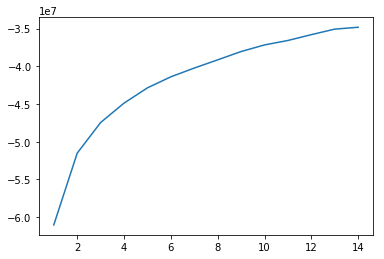

In [42]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(cluster_counts,avg_distance)

In [43]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans=KMeans(n_clusters=12,random_state=47)
model=kmeans.fit(pca_reapplied)


In [44]:
fully_encoded_scaled['cluster']=model.labels_


In [45]:
fully_encoded_scaled.cluster.value_counts(normalize=True)

10    0.129611
1     0.113618
2     0.109350
6     0.103062
11    0.100479
8     0.086888
9     0.078267
7     0.075368
5     0.064272
3     0.054469
4     0.043330
0     0.041285
Name: cluster, dtype: float64

### Discussion 3.1: Apply Clustering to General Population

I have decided to segment the customer data into 12 clusters .This is because within cluster distance begins to flatten out after 12 clusters

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [46]:
# Load in the customer demographics data.
test=pd.read_csv('Udacity_CUSTOMERS_Subset.csv',delimiter=';')

test_1=test.copy()
lesser_than_threshold_customer,cleaned_test_customer,greater_than_threshold_customer=clean_data(test_1)





/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:109: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


In [47]:
cleaned_test_customer.shape

(787544, 196)

In [48]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customer_scaled=scaler.transform(cleaned_test_customer.values)
pca_customer_applied=pca.transform(customer_scaled)


model_2=kmeans.predict(pca_customer_applied)

customer_scaled_df=pd.DataFrame(customer_scaled)

customer_scaled_df.columns=cleaned_test_customer.columns



In [49]:
customer_scaled_df['cluster']=model_2
customer_scaled_df['cluster'].value_counts()

10    102214
1      89512
2      85956
6      81047
11     79061
8      68213
9      61612
7      59332
5      50533
3      42827
4      34568
0      32669
Name: cluster, dtype: int64

[Text(0,0.5,'Count')]

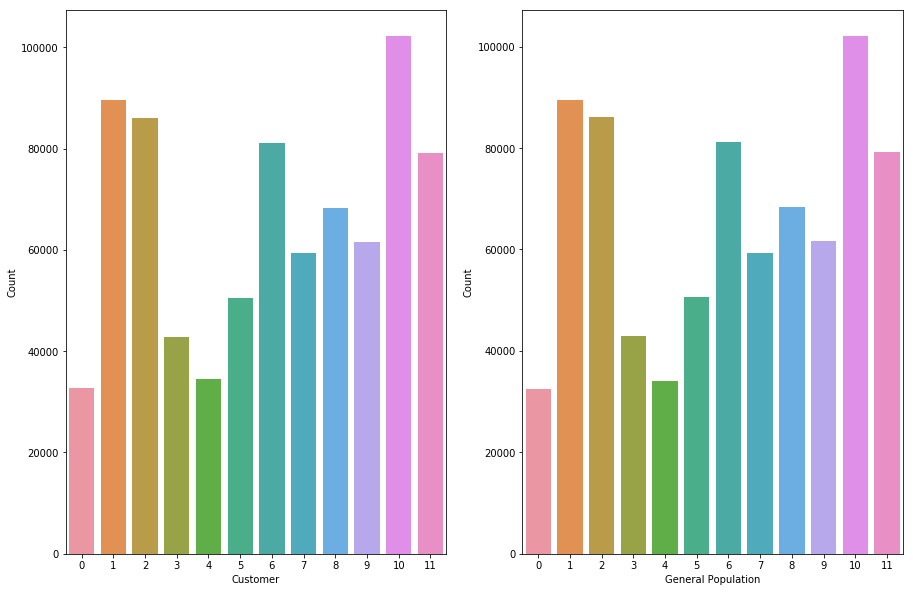

In [51]:
fig, ax =plt.subplots(1,2,figsize=(15,10))

ax1=sns.countplot(x='cluster',data=customer_scaled_df,ax=ax[0])
ax2=sns.countplot(x='cluster',data=fully_encoded_scaled, ax=ax[1])
ax1.set_xlabel('Customer')
ax2.set_xlabel('General Population')


ax1.set(ylabel="Count")
ax2.set(ylabel="Count")


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [52]:
columns_to_consider=greater_than_threshold.columns[-5:]

print (lesser_than_threshold[columns_to_consider].isnull().sum()/len(lesser_than_threshold[columns_to_consider]),greater_than_threshold[columns_to_consider].isnull().sum()/len(greater_than_threshold[columns_to_consider]))
print (lesser_than_threshold_customer[columns_to_consider].isnull().sum()/len(lesser_than_threshold_customer[columns_to_consider]),greater_than_threshold_customer[columns_to_consider].isnull().sum()/len(greater_than_threshold_customer[columns_to_consider]))



PLZ8_HHZ       0.017113
PLZ8_GBZ       0.017113
ARBEIT         0.005280
ORTSGR_KLS9    0.005162
RELAT_AB       0.005280
dtype: float64 PLZ8_HHZ       0.993837
PLZ8_GBZ       0.993837
ARBEIT         0.899110
ORTSGR_KLS9    0.899033
RELAT_AB       0.899110
dtype: float64
PLZ8_HHZ       0.017113
PLZ8_GBZ       0.017113
ARBEIT         0.005280
ORTSGR_KLS9    0.005162
RELAT_AB       0.005280
dtype: float64 PLZ8_HHZ       0.993837
PLZ8_GBZ       0.993837
ARBEIT         0.899110
ORTSGR_KLS9    0.899033
RELAT_AB       0.899110
dtype: float64


- From the comparison above we can see that  for a handful of 5 features distribution of data between high threshold and lower
  threshold data is indeed found to be different.Some features have as much as 99% of their data to be missing.
  
- This comparison though holds good for customers and general population data as well

In [54]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

#find out the difference between customer data and general population in terms of cluster distribution

print ((customer_scaled_df.cluster.value_counts(normalize=True)-fully_encoded_scaled.cluster.value_counts(normalize=True)).sort_values(ascending=False))


 

4     0.000564
0     0.000197
10    0.000178
1     0.000042
7    -0.000030
9    -0.000034
3    -0.000089
11   -0.000090
5    -0.000107
6    -0.000151
2    -0.000206
8    -0.000273
Name: cluster, dtype: float64


### From the above data we can infer that cluster 4 is 0.05% underrepresented in general population compared to customers and population belonging to these clusters can be  target population for the company to pursue

* Cluster 4,0,10,1 are the overrepresented clusters in descending order of over representation

In [55]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?



#Filter on cluster 1 
cust_cluster_4=customer_scaled_df[customer_scaled_df['cluster']==4]

#extract top 30 pca components  of a cluster and extract top 3 features based on their highest weights
top_3_features=[]
for i in range(0,30): #extract 30 components
    temp=cust_cluster_4.iloc[i,:].sort_values(ascending=False)[:3].index.values.tolist()
    
    top_3_features.extend(temp) #supply indexes of the top 3 features for every component


top_3_features_d={x:top_3_features.count(x) for x in top_3_features}

top_3_features_d_sorted= sorted(top_3_features_d.items(),key=operator.itemgetter(1))

In [56]:
#Sort the top occuring features of people belonging to cluster1
top_3_features_d_sorted

[('GEBAEUDETYP_6.0', 1),
 ('CAMEO_DEU_2015_33.0', 1),
 ('CAMEO_DEU_2015_40.0', 1),
 ('CAMEO_DEU_2015_11.0', 1),
 ('CAMEO_DEU_2015_32.0', 1),
 ('GFK_URLAUBERTYP_4.0', 1),
 ('CAMEO_DEU_2015_29.0', 1),
 ('CAMEO_DEU_2015_35.0', 1),
 ('CAMEO_DEUG_2015_8.0', 1),
 ('CAMEO_DEU_2015_25.0', 1),
 ('CAMEO_DEU_2015_34.0', 1),
 ('CAMEO_DEU_2015_28.0', 1),
 ('LP_STATUS_FEIN_4.0', 1),
 ('CAMEO_DEU_2015_19.0', 1),
 ('ZABEOTYP_4.0', 1),
 ('CAMEO_DEU_2015_38.0', 1),
 ('CAMEO_DEU_2015_1.0', 1),
 ('LP_STATUS_FEIN_5.0', 1),
 ('CAMEO_DEU_2015_27.0', 2),
 ('CAMEO_DEU_2015_13.0', 2),
 ('NATIONALITAET_KZ_3.0', 2),
 ('CAMEO_DEU_2015_26.0', 2),
 ('CAMEO_DEU_2015_2.0', 3),
 ('LP_FAMILIE_GROB_4.0', 3),
 ('FINANZTYP_5.0', 4),
 ('LP_FAMILIE_FEIN_7.0', 5),
 ('CAMEO_DEU_2015_12.0', 6),
 ('LP_FAMILIE_FEIN_5.0', 12),
 ('LP_FAMILIE_FEIN_4.0', 13),
 ('cluster', 18)]

### We can see the top occuring features among  people belonging to cluster 3 as :

* LP_FAMILIE_FEIN_4.0 : Single parent with teenager
* LP_FAMILIE_FEIN_5: Single parent with child of full age
* CAMEO_DEU_2015_12.0: Journeymen
* LP_FAMILIE_FEIN_7.0: investor
* LP_FAMILIE_GROB_4.0 - family type (6-8)



    
    


####  Clusters 7,9,3,11,5,6,2,8 seem to be the underepresented clusters with decreasing order or underrepresentation 

In [58]:
#Filter on cluster 13
cust_cluster_7=fully_encoded_scaled[fully_encoded_scaled['cluster']==7]

#extract top 30 pca components  of a cluster and extract top 3 features based on their highest weights
top_3_features=[]
for i in range(0,30): #extract 30 components
    temp=cust_cluster_7.iloc[i,:].sort_values(ascending=False)[:3].index.values.tolist()
    
    top_3_features.extend(temp) #supply indexes of the top 3 features for every component


top_3_features_d={x:top_3_features.count(x) for x in top_3_features}

top_3_features_d_sorted= sorted(top_3_features_d.items(),key=operator.itemgetter(1))

top_3_features_d_sorted

[('CAMEO_DEU_2015_24.0', 1),
 ('FINANZTYP_5.0', 1),
 ('CAMEO_DEU_2015_22.0', 1),
 ('CAMEO_DEU_2015_6.0', 1),
 ('CAMEO_DEUG_2015_2.0', 1),
 ('CAMEO_DEU_2015_21.0', 1),
 ('LP_STATUS_FEIN_2.0', 1),
 ('CAMEO_DEU_2015_37.0', 1),
 ('GFK_URLAUBERTYP_10.0', 1),
 ('LP_STATUS_FEIN_5.0', 1),
 ('CAMEO_DEU_2015_20.0', 1),
 ('CAMEO_DEU_2015_14.0', 1),
 ('GFK_URLAUBERTYP_1.0', 1),
 ('CAMEO_DEU_2015_36.0', 1),
 ('GFK_URLAUBERTYP_7.0', 1),
 ('GFK_URLAUBERTYP_12.0', 1),
 ('GFK_URLAUBERTYP_4.0', 1),
 ('GFK_URLAUBERTYP_11.0', 2),
 ('CAMEO_DEU_2015_29.0', 2),
 ('NATIONALITAET_KZ_2.0', 2),
 ('CAMEO_DEU_2015_3.0', 2),
 ('CAMEO_DEU_2015_15.0', 2),
 ('ZABEOTYP_6.0', 2),
 ('CAMEO_DEUG_2015_7.0', 2),
 ('CAMEO_DEU_2015_4.0', 3),
 ('CAMEO_DEU_2015_7.0', 3),
 ('LP_FAMILIE_FEIN_5.0', 3),
 ('CAMEO_DEU_2015_38.0', 3),
 ('NATIONALITAET_KZ_3.0', 5),
 ('FINANZTYP_2.0', 6),
 ('CAMEO_DEU_2015_27.0', 6),
 ('cluster', 30)]

### Shown below are some characteristics of people who have been overrepresented in the general population compared to customers .We can infer that these are properties of people that would not fall under our customer category .Some features do over lap with the features of people who are our customers but an in depth analysis would help us understand what are the unique properties of people we want to target as our customers are and we can stick to attracting those kinds of people only

* 'LP_FAMILIE_FEIN_5.0'      : Family type, single parent with child of full age
* 'CAMEO_DEU_2015_38.0' :  Established gourmet
* 'CAMEO_DEU_2015_27'  :  Wealth / Life Stage Typology- Empty Nest
* 'FINANZTYP_2.0'    : Most descriptive financial type for individual- money saver
  



### Discussion 3.3: Compare Customer Data to Demographics Data

As a summary of the findings that we have had from above analyses we can infer that :

General Population belonging to cluster  4,0,10,1 are people that the mail order company should potentially target as customers .

General Population belonging to cluster  7,9,3,11,5,6,2,8    are people that the mail order company should potentially avoid as customers .

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.